<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Exercises for the course<br>
        <b>Machine Learning for Data Science</b><br>
    Winter Semester 2024/25
    </p>
</td>
<td style='background-color:white'>
    G. Montavon<br>
    Institute of Computer Science<br>
    <b>Department of Mathematics and Computer Science</b><br>
    Freie Universität Berlin
</td>
</tr>
</table>

<br>
<center>
    <h1>Exercise Sheet 2 (programming part)</h1>
</center>
<br>

We first load a small handwritten digits dataset provided as part of the scikit-learn library and a few relevant libraries.

In [23]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy
import torch,torch.optim
import scipy,scipy.spatial
import sklearn, sklearn.datasets

dataset = sklearn.datasets.load_digits()
X = dataset['data']
T = dataset['target']
R = numpy.random.mtrand.RandomState(0).permutation(len(X))[:750]
X = X[R]
T = T[R]

## Exercise 3: Implementing Metric MDS (15+15+10 P)

In this exercise, we will implement a low-dimensional embedding technique, multi-dimensional scalling (MDS), apply it to the simple handwritten digits dataset above, and visualize the embedded data using a series of scatter plots.

The MDS algorithm does not operate with the dataset directly, but instead, with a matrix of distances. Also, in order to be rather independent from the scale and dimensionality of the data, we would like to normalize the input distance such that distances are on average 10. Lastly, the distance should be provided as a torch tensor so that it can be used for the gradient-based training procedure. 

**(a)** Write a function that takes the data as input and returns a distance matrix according to the specifications above.

In [24]:
D = scipy.spatial.distance.cdist(X,X)

t = torch.tensor(D, dtype=torch.float32)

# normalize distances to mean 10

avg = torch.mean(t)
normalization = 10 / avg.item()
normD = t * normalization


print(f"shape: {str(normD.shape)}")
print(f"min:   {normD.min():6.3f}")
print(f"mean:  {normD.mean():6.3f}")
print(f"max:   {normD.max():6.3f}")

shape: torch.Size([750, 750])
min:    0.000
mean:  10.000
max:   15.391


We now would like learn Metric MDS. We will consider a simple gradient-based implementation. The outline of the gradient-based procedure is provided in the code below. The only part missing is the computation of the objective $J(Y)$ where $Y$ are the matrix of size $N \times 2$ containing the coordinates of data points in embedded space. As a reminder, the metric MDS objective the is given by:
$$J(\boldsymbol{y}_1,\dots,\boldsymbol{y}_N) = \left(\frac{\sum_{i<j} \big(d_{ij} - \|\boldsymbol{y}_i - \boldsymbol{y}_j\|\big)^2}{\sum_{i<j} d_{ij}^2}\right)^{\frac12}$$

**(b)** Complete the code below by expressing `J` as a function of `Y` and `D`.

*(Hint: Running the training procedure may take up to 5 minutes. For debugging purposes, you can temporarily reduce the number of iterations.)*

In [25]:
Y = torch.randn([len(X),2])*5
Y.requires_grad_(True)

optimizer = torch.optim.SGD((Y,), lr=100.0, momentum=0.95)

Yhist = []

for i in range(10**4+1):
    optimizer.zero_grad()

    # compute the low-dimensional distances
    low_dist = torch.cdist(Y, Y, p=2)
    
    # compute the difference between the distances
    diff_dist = normD - low_dist
    numerator = torch.sum(diff_dist**2)
    denominator = torch.sum(normD**2)
    
    
    # objective function
    J = torch.sqrt(numerator / denominator)
    J.requires_grad_(True)
    
    # backpropagate
    J.backward()

    # Keep track of the objective
    if i in numpy.arange(11)**4:
        print(f"{i:5d} {J.data.numpy():.3f}")
        Yhist += [Y.data.numpy()*1.0]
        
    optimizer.step()

    0 0.500
    1 0.500
   16 0.465
   81 0.425
  256 0.412
  625 0.365
 1296 0.337
 2401 0.332
 4096 0.330
 6561 0.330
10000 0.329


The code above has stored the embedding at 11 distinct checkpoints (available in `Yhist`). This allows to visualize how the embedding (initialized at random) evolves throughout training, and how it progressively progressively improves the representation of distances in the data.

**(c)** Using matplotlib, plot the embedding at checkpoints {0,3,4,5,6,10}, and color-code the embedding according to the digit's class *(Hint: because there are 10 classes, you can use of the colormap `tab10` in matplotlib.)*

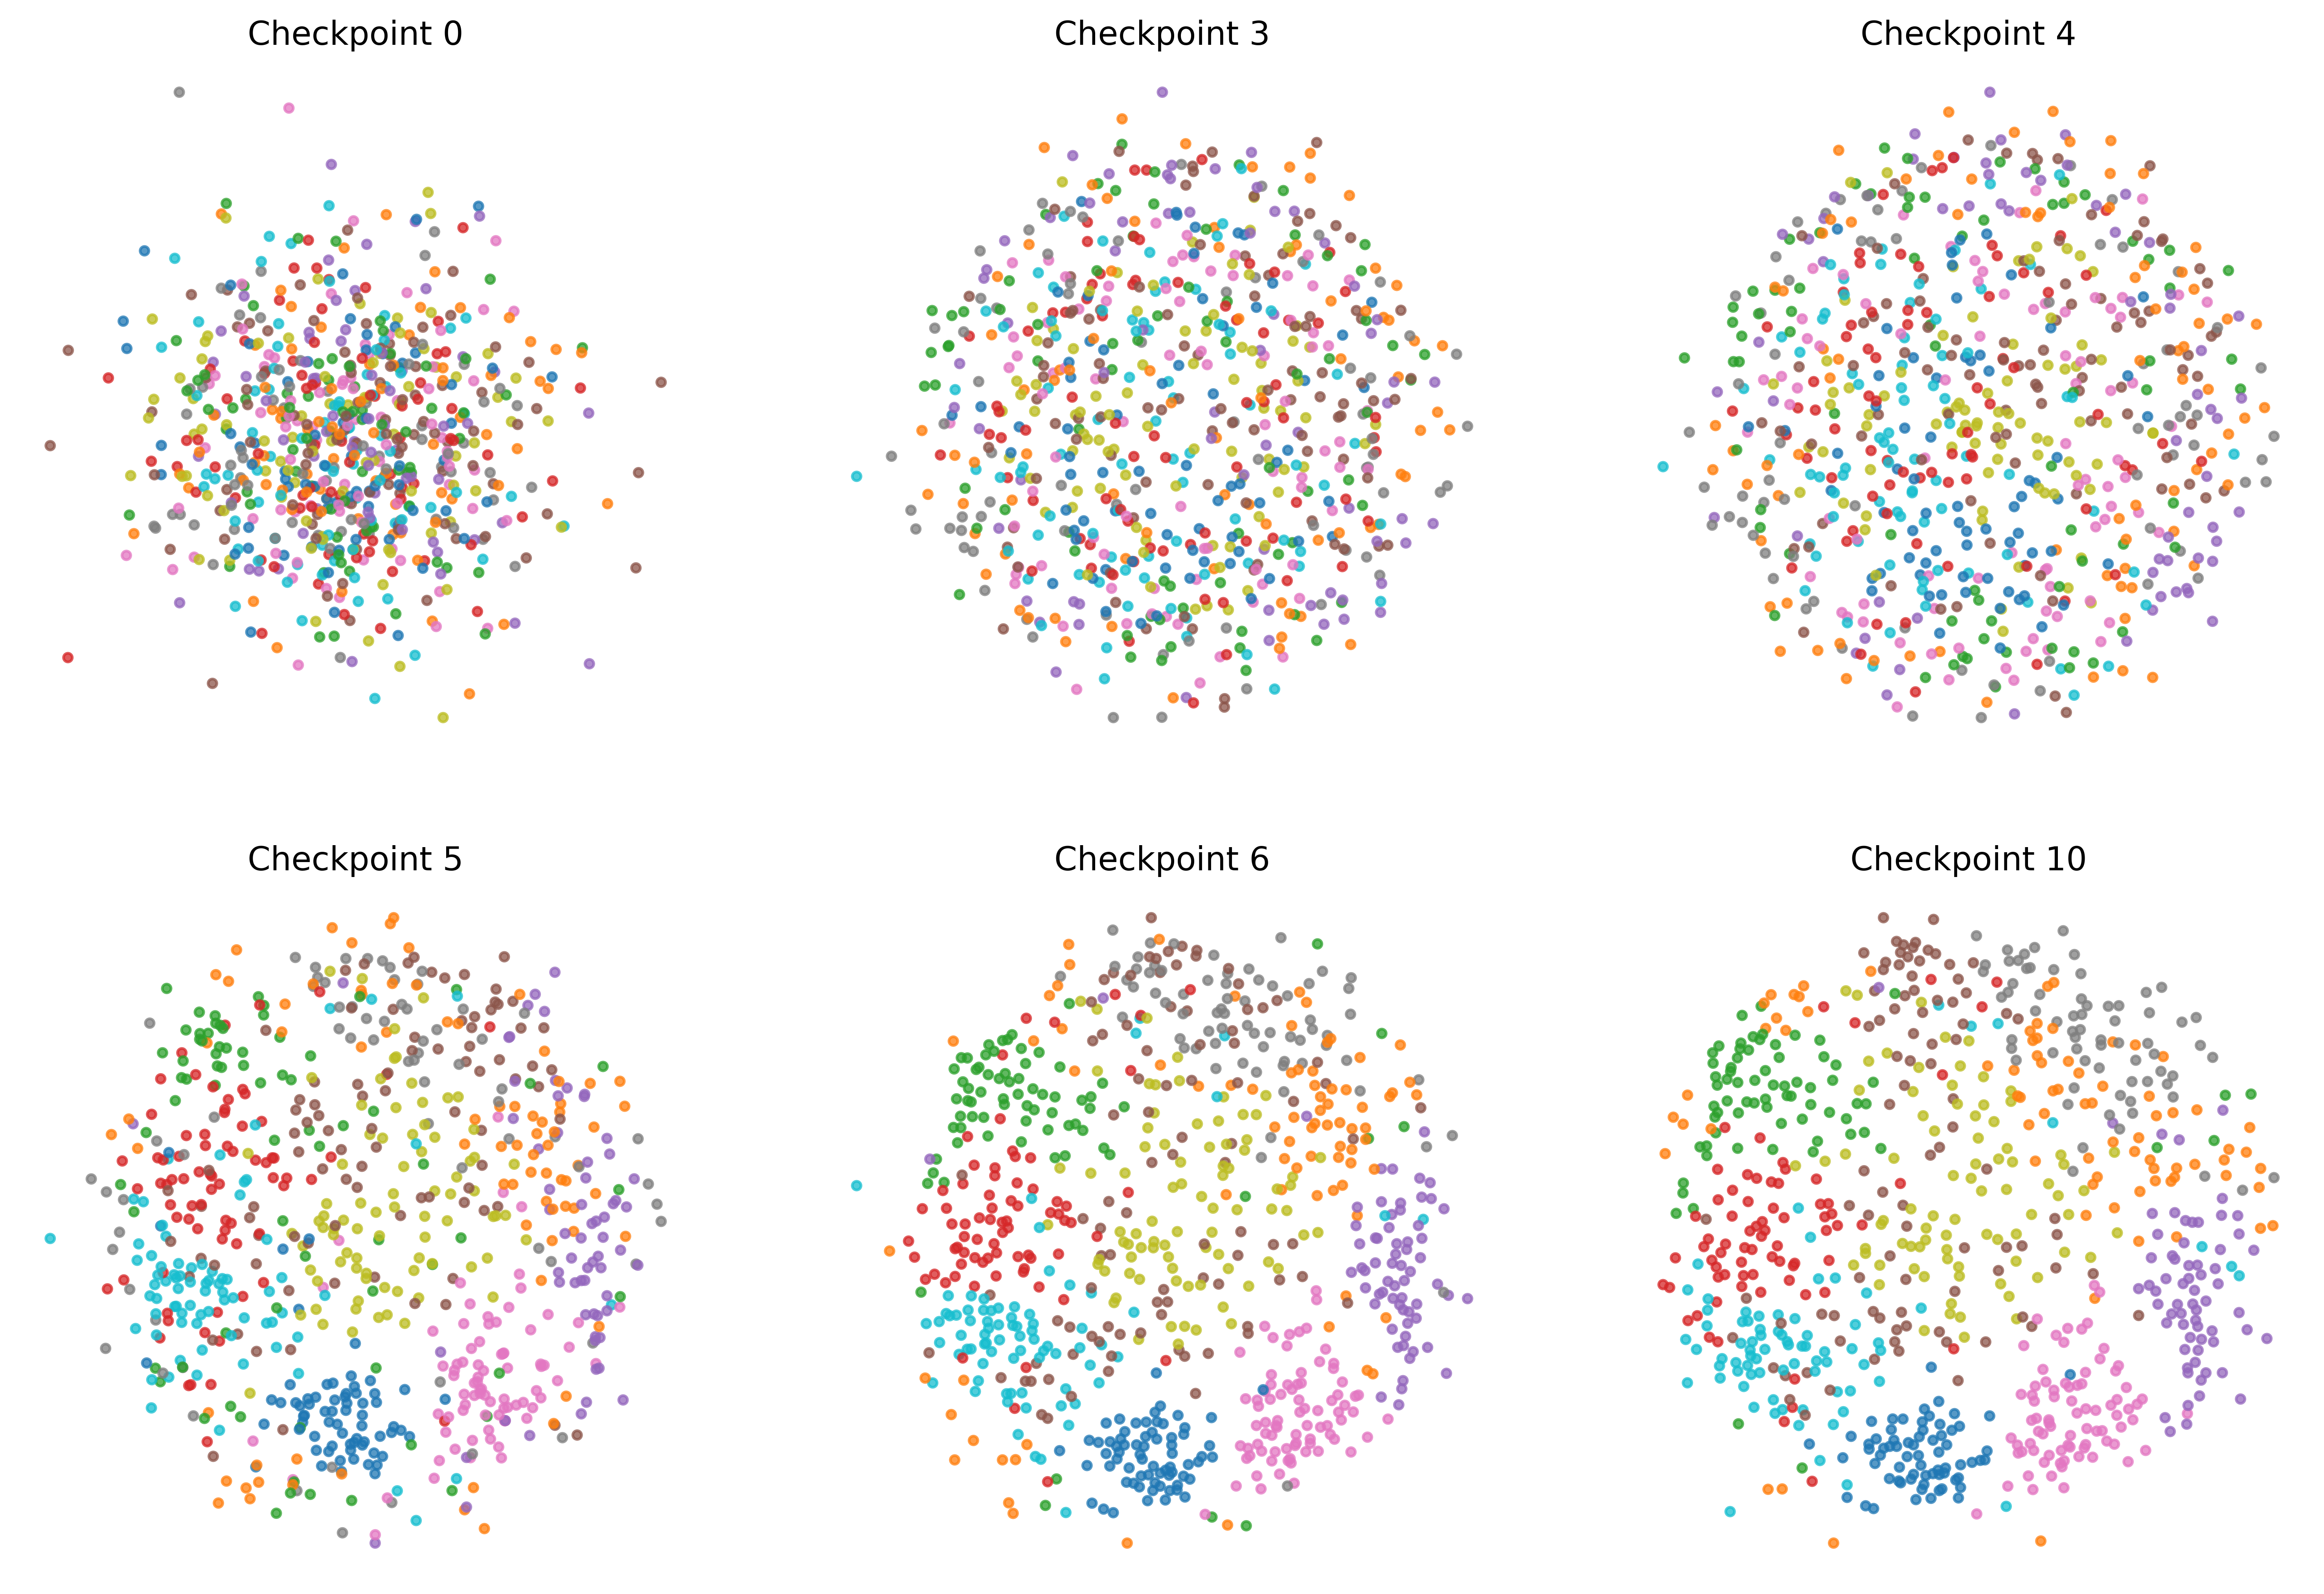

In [29]:
checkpoints = [0, 3, 4, 5, 6, 10]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=500)
axes = axes.flatten()

for idx, checkpoint in enumerate(checkpoints):
    embedding = Yhist[checkpoint]
    ax = axes[idx]
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=T, cmap='tab10', s=10, alpha=0.75)
    ax.set_title(f'Checkpoint {checkpoint}')
    ax.axis('off')

plt.show()

We observe that during training, data points travel in embedded space. In the final configuration, embedded data forms clusters of points of same class.